# Atmospheric Data

Let's start our discussion by stating something obvious: our models fly through the air. Air is a fluid, even if that is not obvious. It is just a very thin fluid and we need to know a few fundamental properties of that fluid to do much interesting work.

In this discussion, we will be referring to numbers that are presented with units in some common system of measurement. Just using bare numbers for any engineering work is just asking for trouble, and mixing systems of measure is equally dangerous (Ask NASA about a recent Mars Lander mission that failed due to this!). We will use the Python **pint** package to attach units to numbers for this example. This is something many programmers have never seen!

```{note} This next block prepares this page so it can access my Python code and insert images. You can ignore this.
```

In [1]:
import os
import sys
from IPython.display import Image
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

Rather than rely on local measurements of the properties of air, most researchers use a model atmosphere so they can compare results. We will use data from the *1976 Standard Atmospheric Model*, which you can find at the [Standard Atmosphere Calculator](https://www.digitaldutch.com/atmoscalc/). The website at that link lets you set your elevation and it presents you with standard values for the important properties we will need.

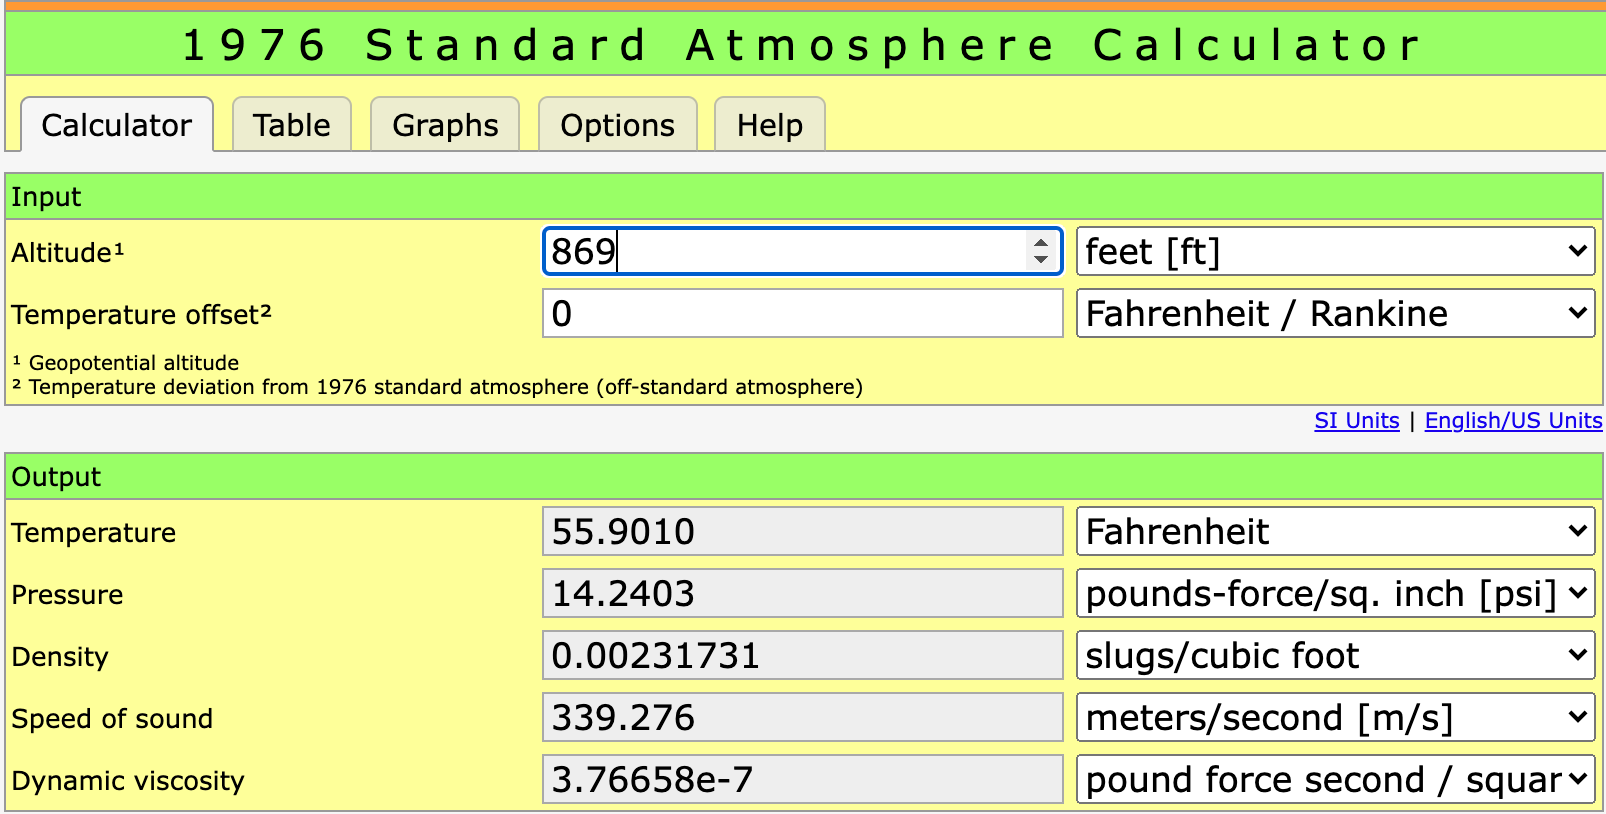

In [2]:
Image(filename='../../assets/images/osawatomie-std-atm.png')

The Python **fluids** package implements this model, so we do not have to copy and paste numbers from the web site. However that package does not handle the units for those numbers, so I created a wrapper routine that adds units and returns four basic properties for any specified elevation:

- Temperature
- Pressure
- Density
- Dynamic Viscosity

## Unit Conversions

To get started, here is the coe that creates our basic *Unit Registry*:

In [7]:
import pint
u = pint.UnitRegistry()

Let's see what the standard atmosphere says about our local indoor site, which sits at an elevation of 869 feet above sea level;

In [8]:
from mmtime.StdAtm import Air

site_elevation = 869 # feet
std = Air(u).get_properties(site_elevation)
for key in std:
    print(f'{key} = {std[key]}')

T = 282.50227207113966 kelvin
P = 91313.19385328887 pascal
rho = 1.1260285168079938 kilogram / meter ** 3
mu = 1.761999988782331e-05 pascal * second


Internally, **pint** manages units in the metric system. Here is how pressure looks in that system:

In [9]:
pressure = std['P'].to_base_units()
pressure

91313.19385328887 <Unit('kilogram / meter / second ** 2')>

We need to be careful here. Pressure is a force per unit area, but grams here are a mass term. We need to factor in the force of gravity, and use Newton's second law ($F = ma$) to get this right:

In [10]:
print((pressure/u.gravity).to('lb/inch**2'))

13.243859061401066 pound / inch ** 2


Forgetting to include the acceleration of gravity is a common way to get units wrong. **pint** can help you track down those errors!

## Reynold's Number Calculator

Many of the calculations we will perform use data that is dependent on the *Reynold's number*. This dimensionless number was invented by George Stokes in 1851, but was promoted widely by Osborne Reynolds and it was named in his honor. It is a measure of the ratio of inertial forces to viscous forces any object experiences while moving through a fluid. It is used to characterize the kind of flow that will develop around that object. 

Let's see what a typical *Reynold's Number might* be for our model. This will also show how **pint** can help you confirm that your units are correct.

Here is the definition of the Reynold's Number:

\begin{equation}
RE = \frac{\rho V L}{\mu}
\end{equation}

where

- $\rho$ - the density of the fluid
- $V$ - the velocity of the moving object ( or the fluid if the object is stationary)
- $L$ - some characteristic length. Commonly this is wing chord.
- $\mu$ - the dynamic viscosity of the fluid

Two of these numbers come directly from our flying site data, and the length comes from the model. The big unknown at this point is the flight velocity. From conversations with Gary about flights of the Wart, he estimated the flight velocity at around two miles per hour. We will start off with that number as a test:

In [20]:
V = 2.0 * u.miles / u.hour
L = 2.0 * u.inch
RE = std['rho'] * V * L / std['mu']
RE

255625.09057361813 <Unit('inch * kilogram * mile / hour / meter ** 3 / pascal / second')>

Phew! That does not look right. **pint** may not display the units you expect, but you can force it a bit:

In [21]:
RE.to_base_units()

2902.575868446768 <Unit('dimensionless')>

Now this is correct. The Reynolds number is one of many numbers we work with in aerodynamics that are dimensionless. **pint** can deal with numbers that have no units nicely!

If you ntices, I used a variety of units of measure in that calculation and **pint** handled all of that with no problems!

Next, we need a model that will fly through this air!